In [74]:
import torch as T
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set()

In [75]:
!ls train_checkpoins/

Imitation_AsteroidsNoFrameskip-v4.final_checkpoint.zip
Imitation_BipedalWalker-v3
Imitation_BreakoutNoFrameskip-v4.final_checkpoint.zip
Imitation_LunarLander-v2
Imitation_MountainCar-v0
Imitation_MsPacmanNoFrameskip-v4.final_checkpoint.zip
Imitation_PongNoFrameskip-v4.final_checkpoint.zip
Online_AsteroidsNoFrameskip-v4.final_checkpoint.zip
Online_BipedalWalker-v3
Online_BreakoutNoFrameskip-v4.final_checkpoint.zip
Online_LunarLander-v2
Online_MountainCar-v0
Online_MsPacmanNoFrameskip-v4.final_checkpoint.zip
Online_PongNoFrameskip-v4.final_checkpoint.zip
[1_4]Imitation_AsteroidsNoFrameskip-v4.final_checkpoint.zip
[1_4]Imitation_BreakoutNoFrameskip-v4.final_checkpoint.zip
[1_4]Imitation_MsPacmanNoFrameskip-v4.final_checkpoint.zip
[1_4]Imitation_PongNoFrameskip-v4.final_checkpoint.zip


In [76]:
class Logger:

    def __init__(self, print_rate=250):
        self.log = {'ep_r':[], 'ep_l':[], 'loss':[]}
        self.n_ep = 0              # total games/episodes
        self.n_update = 1          # total weight updates
        self.n_frames = 0          # env steps (total from checkpoint)
        self.run_frames = 0        # env steps (for this run)
        self.max_rwd = -np.inf     # max rwd out of all games played
        self.start_time = time()   # time we started *this* run
        self.last_checkpoint = 0   # total_frames at last checkpoint
        self.print_rate = print_rate

    def eta(self):  # get hh:mm:ss left to train
        elapsed_time = time() - self.start_time
        frames_left = ONLINE_STEPS - self.n_frames
        sec_per_frame = elapsed_time / self.n_frames
        sec_left = int(frames_left * sec_per_frame)
        eta_str = str(datetime.timedelta(seconds=sec_left))
        return eta_str

    def fps(self):  # get frames per second
        elapsed_time = time() - self.start_time
        fps = int(self.run_frames / elapsed_time)
        return fps

    def sma(self, x):  # simple moving average
        if not x: return 0
        div = 50 if len(x) > 50 else len(x)
        return sum(list(zip(*x[-div:]))[-1])/div

    def print_log(self):
        fps = self.fps()
        eta = self.eta()
        print('-'*10, self.n_update, '/', ONLINE_STEPS, '-'*10)
        print('Num Games:', self.n_ep)
        print('Num Frames:', self.n_frames)
        print('FPS:', fps)
        print('ETA:', eta)
        print(f'SMA Length: {self.sma(self.log["ep_l"]):.3f}')
        print(f'SMA Reward: {self.sma(self.log["ep_r"]):.3f}')
        print(f'SMA Loss: {self.sma(self.log["loss"]):.3f}')
        print('Max reward:', self.max_rwd)

    def record(self, ep, loss):
        
        self.n_update += 1
        self.n_frames += 1
        self.run_frames += 1
        fr = (self.n_frames, self.n_update)

        # stats about finished episodes/games
        if ep:
            self.log['ep_l'].append(fr+(ep['l'],))
            self.log['ep_r'].append(fr+(ep['r'],))
            if ep['r'] > self.max_rwd: self.max_rwd = ep['r']
            self.n_ep += 1
             
        # nn training statistics
        if loss:
            self.log['loss'].append(fr+(loss,))
        
        # print log
        if self.n_update % self.print_rate == 0:
            self.print_log()

In [71]:
def plot_comparison(online_fn, imitation_fn, imitation_fn2, title):
    online = T.load(online_fn, map_location='cpu')
    imitation = T.load(imitation_fn, map_location='cpu')
    imitation2 = T.load(imitation_fn2, map_location='cpu')
    online_r = online['logger'].log['ep_r']
    imitation_r = imitation['logger'].log['ep_r']
    imitation_r2 = imitation2['logger'].log['ep_r']

    # compute rolling avg and std
    df = pd.DataFrame(online_r, columns =['Steps', 'Iters', 'reward_online'])
    df['reward_imitation'] = [x[2] for x in imitation_r[:len(df)]]
    df['reward_imitation2'] = [x[2] for x in imitation_r2[:len(df)]]
    df = df.dropna()
        
    df['online_sma'] = df['reward_online'].rolling(100, min_periods=1).mean()
    df['online_std'] = df['reward_online'].rolling(100, min_periods=1).std()
    df['imitation_sma'] = df['reward_imitation'].rolling(100, min_periods=1).mean()
    df['imitation_std'] = df['reward_imitation'].rolling(100, min_periods=1).std()
    df['imitation2_sma'] = df['reward_imitation2'].rolling(100, min_periods=1).mean()
    df['imitation2_std'] = df['reward_imitation2'].rolling(100, min_periods=1).std()
    
    # plot with seaborn
    fig, ax = plt.subplots(figsize=(4,4))
    ax.set_title(title)
    ax.set_xlabel('Timesteps')
    ax.set_ylabel('Reward')
    clrs = sns.color_palette("husl", 8)

    # fill standard deviation
    ax.plot(df['Steps'], df['online_sma'], label='Online', c=clrs[0])
    ax.fill_between(df['Steps'], df['online_sma']-df['online_std'],  df['online_sma']+df['online_std'], 
                    alpha=0.3, facecolor=clrs[0]) 
    
    ax.plot(df['Steps'], df['imitation_sma'], label='Imitation 50/50', c=clrs[2])
    ax.fill_between(df['Steps'], df['imitation_sma']-df['imitation_std'],  df['imitation_sma']+df['imitation_std'], 
                    alpha=0.3, facecolor=clrs[2]) 
    
    ax.plot(df['Steps'], df['imitation2_sma'], label='Imitation 1/4', c=clrs[4])
    ax.fill_between(df['Steps'], df['imitation2_sma']-df['imitation2_std'],  df['imitation2_sma']+df['imitation2_std'], 
                    alpha=0.3, facecolor=clrs[4]) 
    
    ax.legend(loc='upper left')
    plt.savefig('figures/'+title+'.png', dpi=300)
    plt.show()

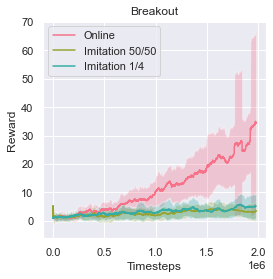

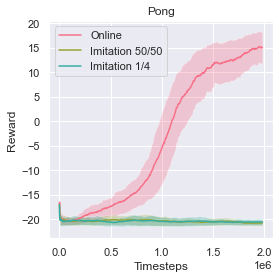

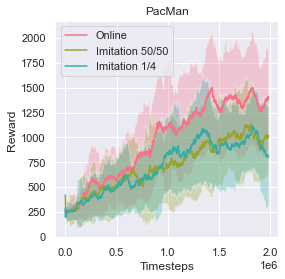

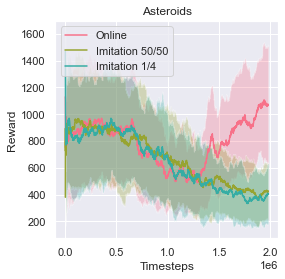

In [72]:
plot_comparison(
    'train_checkpoins/Online_BreakoutNoFrameskip-v4.final_checkpoint.zip', 
    'train_checkpoins/Imitation_BreakoutNoFrameskip-v4.final_checkpoint.zip',
    'train_checkpoins/[1_4]Imitation_BreakoutNoFrameskip-v4.final_checkpoint.zip',
    'Breakout'
)

plot_comparison(
    'train_checkpoins/Online_PongNoFrameskip-v4.final_checkpoint.zip', 
    'train_checkpoins/Imitation_PongNoFrameskip-v4.final_checkpoint.zip',
    'train_checkpoins/[1_4]Imitation_PongNoFrameskip-v4.final_checkpoint.zip',
    'Pong'
)

plot_comparison(
    'train_checkpoins/Online_MsPacmanNoFrameskip-v4.final_checkpoint.zip', 
    'train_checkpoins/Imitation_MsPacmanNoFrameskip-v4.final_checkpoint.zip',
    'train_checkpoins/[1_4]Imitation_MsPacmanNoFrameskip-v4.final_checkpoint.zip',
    'PacMan'
)

plot_comparison(
    'train_checkpoins/Online_AsteroidsNoFrameskip-v4.final_checkpoint.zip', 
    'train_checkpoins/Imitation_AsteroidsNoFrameskip-v4.final_checkpoint.zip',
    'train_checkpoins/[1_4]Imitation_AsteroidsNoFrameskip-v4.final_checkpoint.zip',
    'Asteroids'
)

In [80]:
def plot_comparison_continuous(online_fn, imitation_fn, steps, title):
    
    with open(online_fn, "rt") as f:
        _ = f.readline()
        online_df = pd.read_csv(f)
        online_df.sort_values("t", inplace=True)
        online_df.reset_index(inplace=True)
        
    with open(imitation_fn, "rt") as f:
        _ = f.readline()
        imitation_df = pd.read_csv(f)
        imitation_df.sort_values("t", inplace=True)
        imitation_df.reset_index(inplace=True)

    # compute rolling avg and std
    online_sma_y = online_df['r'].rolling(100, min_periods=1).mean()
    online_std_y = online_df['r'].rolling(100, min_periods=1).std()
    imitation_sma_y = imitation_df['r'].rolling(100, min_periods=1).mean()
    imitation_std_y = imitation_df['r'].rolling(100, min_periods=1).std()
    
    # plot with seaborn
    sns.set()
    fig, ax = plt.subplots(figsize=(4,4))
    ax.set_title(title)
    ax.set_xlabel('Timesteps')
    ax.set_ylabel('Reward')
    clrs = sns.color_palette("husl", 8)

    true_x_online = (steps // max(online_df['index'])) * online_df['index']
    true_x_imitation = (steps // max(imitation_df['index'])) * imitation_df['index']

    # fill standard deviation
    ax.plot(true_x_online, online_sma_y, c=clrs[0], label='Online')
    ax.fill_between(true_x_online, online_sma_y-online_std_y,  online_sma_y+online_std_y, 
                    alpha=0.3, facecolor=clrs[0]) 
    
    ax.plot(true_x_imitation, imitation_sma_y, c=clrs[4], label='Imitation')
    ax.fill_between(true_x_imitation, imitation_sma_y-imitation_std_y,  imitation_sma_y+imitation_std_y, 
                    alpha=0.3, facecolor=clrs[4]) 
    
    ax.legend(loc='upper left')
    plt.savefig('figures/'+title+'.png', dpi=300)
    plt.show()

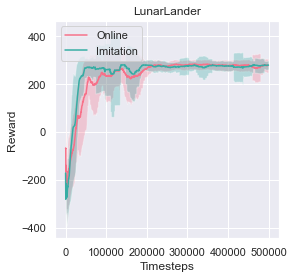

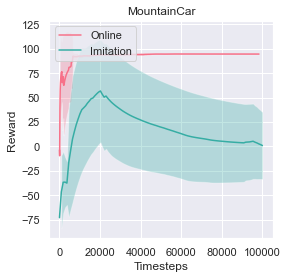

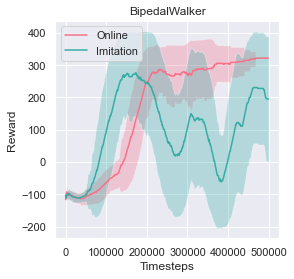

In [81]:
plot_comparison_continuous(
    'train_checkpoins/Online_LunarLander-v2/LunarLanderContinuous-v2.monitor.csv',
    'train_checkpoins/Imitation_LunarLander-v2/LunarLanderContinuous-v2.monitor.csv',
    500000,
    'LunarLander'
)

plot_comparison_continuous(
    'train_checkpoins/Online_MountainCar-v0/MountainCarContinuous-v0.monitor.csv',
    'train_checkpoins/Imitation_MountainCar-v0/MountainCarContinuous-v0.monitor.csv',
    100000,
    'MountainCar'
)

plot_comparison_continuous(
    'train_checkpoins/Online_BipedalWalker-v3/BipedalWalker-v3.monitor.csv',
    'train_checkpoins/Imitation_BipedalWalker-v3/BipedalWalker-v3.monitor.csv',
    500000,
    'BipedalWalker'
)